#### 运行环境 ： python2.7  TensorFlow 1.4.0

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'1.4.0'

## 7.1 TFRecord输入数据格式

### 7.1.1 TFRecord格式介绍

### 7.1.2 TFRecord样例程序

#### 将MNIST输入数据转化为TFRecord格式

In [6]:
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

#### 1. 将输入转化成TFRecord格式并保存。

In [7]:
# 定义函数转化变量类型。
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# 将数据转化为tf.train.Example格式。
def _make_example(pixels, label, image):
    image_raw = image.tostring()
    example = tf.train.Example(features=tf.train.Features(feature={
        'pixels': _int64_feature(pixels),
        'label': _int64_feature(np.argmax(label)),
        'image_raw': _bytes_feature(image_raw)
    }))
    return example

# 读取mnist训练数据。
mnist = input_data.read_data_sets("../data/mnist",dtype=tf.uint8, one_hot=True)
images = mnist.train.images
labels = mnist.train.labels
pixels = images.shape[1]
num_examples = mnist.train.num_examples

# 输出包含训练数据的TFRecord文件。
with tf.python_io.TFRecordWriter("output.tfrecords") as writer:
    for index in range(num_examples):
        example = _make_example(pixels, labels[index], images[index])
        writer.write(example.SerializeToString())
print("TFRecord训练文件已保存。")

# 读取mnist测试数据。
images_test = mnist.test.images
labels_test = mnist.test.labels
pixels_test = images_test.shape[1]
num_examples_test = mnist.test.num_examples

# 输出包含测试数据的TFRecord文件。
with tf.python_io.TFRecordWriter("output_test.tfrecords") as writer:
    for index in range(num_examples_test):
        example = _make_example(
            pixels_test, labels_test[index], images_test[index])
        writer.write(example.SerializeToString())
print("TFRecord测试文件已保存。")

Extracting ../data/mnist/train-images-idx3-ubyte.gz
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz
TFRecord训练文件已保存。
TFRecord测试文件已保存。


In [8]:
mnist = input_data.read_data_sets("../data/mnist",dtype=tf.uint8, one_hot=True)
images = mnist.train.images
labels = mnist.train.labels
pixels = images.shape[1]
num_examples = mnist.train.num_examples

Extracting ../data/mnist/train-images-idx3-ubyte.gz
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz


In [10]:
print images.shape

(55000, 784)

#### 2. 读取TFRecord文件

In [11]:
# 读取文件。
reader = tf.TFRecordReader()
filename_queue = tf.train.string_input_producer(["output.tfrecords"])
_,serialized_example = reader.read(filename_queue)

# 解析读取的样例。
features = tf.parse_single_example(
    serialized_example,
    features={
        'image_raw':tf.FixedLenFeature([],tf.string),
        'pixels':tf.FixedLenFeature([],tf.int64),
        'label':tf.FixedLenFeature([],tf.int64)
    })

images = tf.decode_raw(features['image_raw'],tf.uint8)
labels = tf.cast(features['label'],tf.int32)
pixels = tf.cast(features['pixels'],tf.int32)

sess = tf.Session()

# 启动多线程处理输入数据。
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess,coord=coord)

for i in range(10):
    image, label, pixel = sess.run([images, labels, pixels])

## 7.2 图像数据处理

#### Tensorflow提供了对jpeg和png格式图像的编码/解码函数。以下代码示范对jpeg格式图像进行编码/解码

In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf   
import numpy as np

In [10]:
image_raw_data = tf.gfile.FastGFile("../data/cat.jpg",'rb').read()

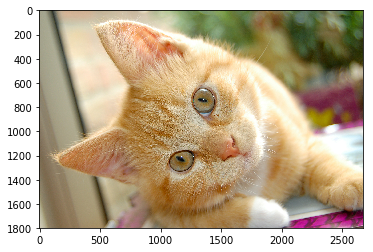

In [15]:
with tf.Session() as sess:
    img_data = tf.image.decode_jpeg(image_raw_data)
    # print img_data.eval()
    plt.imshow(img_data.eval())
    plt.show()
    
    # 将表示一张图像的三维矩阵重新按照jpeg格式编码并存入到文件中。打开图像可以得到一样文件
    encoded_image = tf.image.encode_jpeg(img_data)
    with tf.gfile.GFile("../data/output","wb") as f:
        f.write(encoded_image.eval())

#### 图像大小调整